### Maps Chicago

In [1]:
import fiona
import geopandas as gpd
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\geopandas\_compat.py:152: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\max-admin\AppData\Local\Temp\ipykernel_1732\3192293394.py:2: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [7]:
ca = gpd.read_file("Chigaco_data/boundaries_community_areas_chicago.geojson")
ca = ca.set_index('area_num_1')
ca.reset_index(level=0, inplace=True)
ca.head()

,area_num_1,community,area,shape_area,perimeter,area_numbe,comarea_id,comarea,shape_len,geometry
0,35,DOUGLAS,0,46004621.1581,0,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,36,OAKLAND,0,16913961.0408,0,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,37,FULLER PARK,0,19916704.8692,0,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,38,GRAND BOULEVARD,0,48492503.1554,0,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,39,KENWOOD,0,29071741.9283,0,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [6]:
pickup_aggregated = pd.read_csv("Data/Chigaco_data/chicago_PU_regression.csv")
dropoff_aggregated = pd.read_csv("Data/Chigaco_data/chicago_DO_regression.csv")
pickup_fhv = pd.read_csv("Data/Chigaco_data/chicago_TNP2019_regression.csv")


In [8]:
pickup_aggregated.columns

Index(['date_pickup', 'PULocationID', 'trip_distance_mean',
       'total_amount_mean', 'trip_number', 'STATION', 'NAME', 'DATE', 'AWND',
       'PRCP', 'SNOW', 'SNWD', 'TAVG', 'tmax_obs', 'holiday', 'Weekday_index',
       'Year_fact', 'Month_fact', 'log_total', 'cheby_0', 'cheby_1', 'cheby_2',
       'cheby_3', 'cheby_4', 'cheby_5', 'temp_bins'],
      dtype='object')

In [107]:
pickup = pickup_aggregated.groupby("PULocationID").agg({"trip_number" : "sum"}).reset_index()
dropoff = dropoff_aggregated.groupby("DOLocationID").agg({"trip_number" : "sum"}).reset_index()
pickup["PULocationID"] = pickup["PULocationID"].astype(str)
dropoff["DOLocationID"] = dropoff["DOLocationID"].astype(str)
pickup_merge = ca.merge(pickup, left_on='area_num_1', right_on = "PULocationID", how='left')
pickup_merge.fillna(value = 0, inplace=True)

dropoff_merge = ca.merge(dropoff, left_on='area_num_1', right_on = "DOLocationID", how='left')
dropoff_merge.fillna(value = 0, inplace=True)


In [9]:
pickup_aggt = pickup_fhv.groupby("PULocationID").agg({"trip_number" : "sum"}).reset_index()
pickup_aggt["PULocationID"] = pickup_aggt["PULocationID"].astype(str)
pickup_merge = ca.merge(pickup_aggt, left_on='area_num_1', right_on = "PULocationID", how='left')

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\geopandas\plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
C:\Users\max-admin\AppData\Local\Temp\ipykernel_1732\807770866.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]


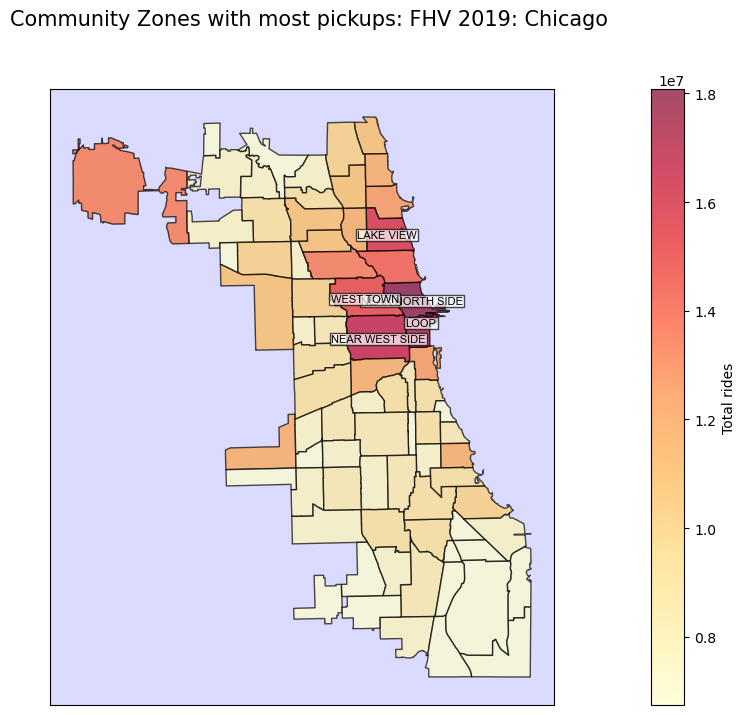

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Sort the DataFrame by 'trip_number' in descending order and get the top 5 zones
top_zones = pickup_merge.sort_values('trip_number', ascending=False).head(5)

# Plot the data with more transparent facecolor
ax = pickup_merge.plot(column='trip_number', scheme='fisher_jenks', k=15, cmap='YlOrRd', legend=False, edgecolor="black", alpha=0.7)
plt.suptitle('Community Zones with most pickups: FHV 2019: Chicago', size=15)
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

# Add colorbar with adjusted transparency
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=top_zones['trip_number'].min(), vmax=top_zones['trip_number'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, alpha=0.7)
cbar.set_label("Total rides")

# Manually adjust the positions of the text annotations
label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]
label_offsets = [(0.001, -0.001), (0.001, 0.005), (0.001, -0.001), (0.001, -0.001), (0.001, -0.001)]

for i, label in enumerate(top_zones.community):
    ax.text(label_positions[i][0] + label_offsets[i][0], label_positions[i][1] + label_offsets[i][1], label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.1', alpha=0.7), fontname='Arial')

# Remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor((0.8, 0.8, 1, 0.7))  # Set facecolor with adjusted transparency

plt.show()



c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\geopandas\plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
C:\Users\max-admin\AppData\Local\Temp\ipykernel_17060\3539209162.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]
C:\Users\max-admin\AppData\Local\Temp\ipykernel_17060\3539209162.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]


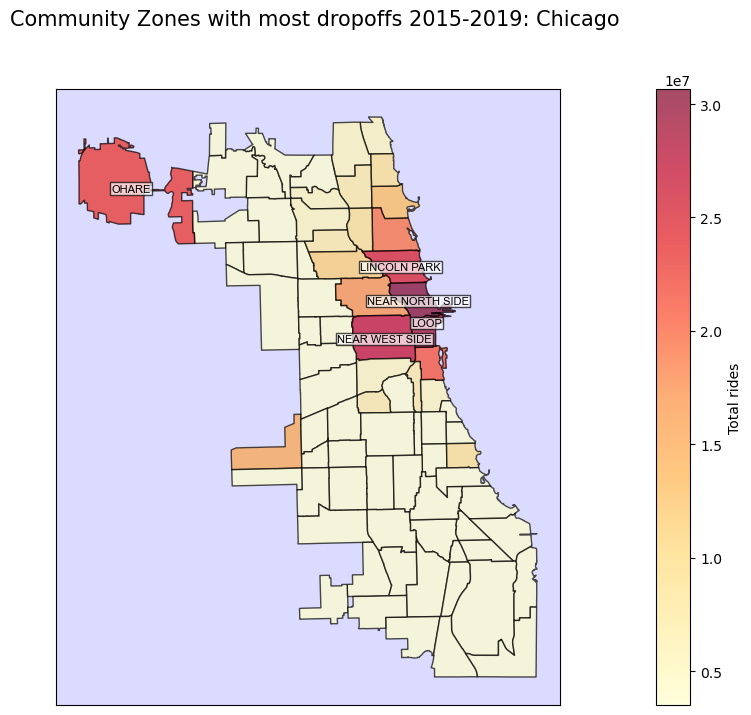

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Sort the DataFrame by 'trip_number' in descending order and get the top 5 zones
top_zones = dropoff_merge.sort_values('trip_number', ascending=False).head(5)

# Plot the data with more transparent facecolor
ax = dropoff_merge.plot(column='trip_number', scheme='fisher_jenks', k=15, cmap='YlOrRd', legend=False, edgecolor="black", alpha=0.7)
plt.suptitle('Community Zones with most dropoffs 2015-2019: Chicago', size=15)
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

# Add colorbar with adjusted transparency
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=top_zones['trip_number'].min(), vmax=top_zones['trip_number'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, alpha=0.7)
cbar.set_label("Total rides")

# Manually adjust the positions of the text annotations
label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]
label_offsets = [(0.001, -0.001), (0.001, 0.005), (0.001, -0.001), (0.001, -0.001), (0.001, -0.001)]

for i, label in enumerate(top_zones.community):
    ax.text(label_positions[i][0] + label_offsets[i][0], label_positions[i][1] + label_offsets[i][1], label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.1', alpha=0.7), fontname='Arial')

# Remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor((0.8, 0.8, 1, 0.7))  # Set facecolor with adjusted transparency

plt.show()


In [118]:
# restrict pickup and dropoff_merge to days where tmax_obs is higher than 30 - this is to avoid the effect of cold weather on the number of trips
pickup_hot = pickup_aggregated[pickup_aggregated["tmax_obs"] > 30]
dropoff_hot = dropoff_aggregated[dropoff_aggregated["tmax_obs"] > 30]

pickup = pickup_hot.groupby("PULocationID").agg({"trip_number" : "sum"}).reset_index()
dropoff = dropoff_hot.groupby("DOLocationID").agg({"trip_number" : "sum"}).reset_index()
pickup["PULocationID"] = pickup["PULocationID"].astype(str)
dropoff["DOLocationID"] = dropoff["DOLocationID"].astype(str)
pickup_merge = ca.merge(pickup, left_on='area_num_1', right_on = "PULocationID", how='left')
pickup_merge.fillna(value = 0, inplace=True)

dropoff_merge = ca.merge(dropoff, left_on='area_num_1', right_on = "DOLocationID", how='left')
dropoff_merge.fillna(value = 0, inplace=True)


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\geopandas\plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
C:\Users\max-admin\AppData\Local\Temp\ipykernel_17060\2587221019.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]
C:\Users\max-admin\AppData\Local\Temp\ipykernel_17060\2587221019.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]


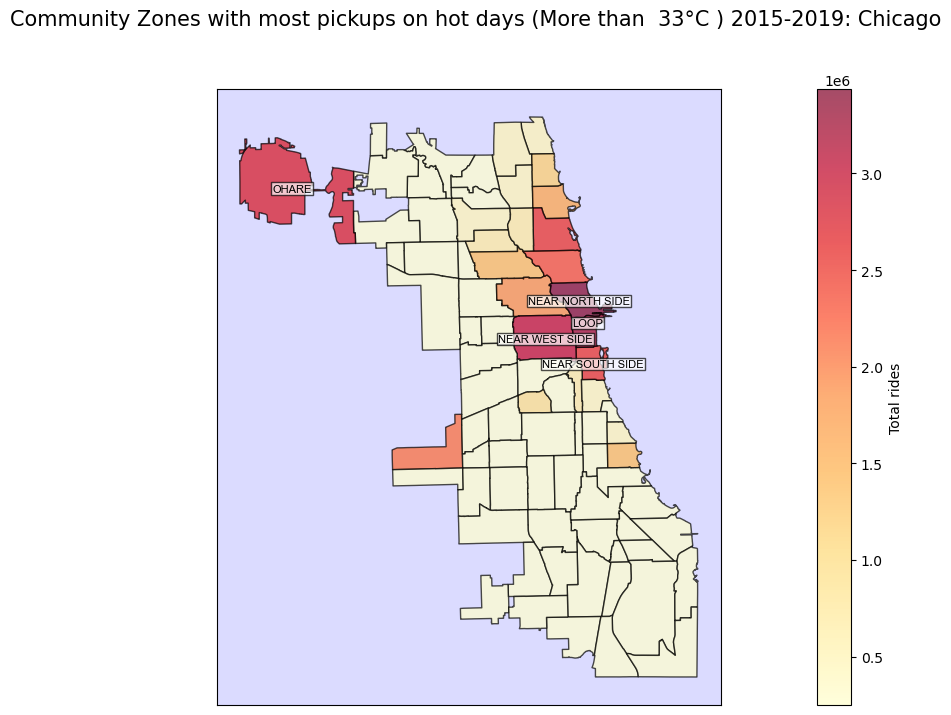

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Sort the DataFrame by 'trip_number' in descending order and get the top 5 zones
top_zones = pickup_merge.sort_values('trip_number', ascending=False).head(5)

# Plot the data with more transparent facecolor
ax = pickup_merge.plot(column='trip_number', scheme='fisher_jenks', k=15, cmap='YlOrRd', legend=False, edgecolor="black", alpha=0.7)
plt.suptitle('Community Zones with most pickups on hot days (More than  33°C ) 2015-2019: Chicago', size=15)
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

# Add colorbar with adjusted transparency
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=top_zones['trip_number'].min(), vmax=top_zones['trip_number'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, alpha=0.7)
cbar.set_label("Total rides")

# Manually adjust the positions of the text annotations
label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]
label_offsets = [(0.001, -0.001), (0.001, 0.005), (0.001, -0.001), (0.001, -0.001), (0.001, -0.001)]

for i, label in enumerate(top_zones.community):
    ax.text(label_positions[i][0] + label_offsets[i][0], label_positions[i][1] + label_offsets[i][1], label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.1', alpha=0.7), fontname='Arial')

# Remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor((0.8, 0.8, 1, 0.7))  # Set facecolor with adjusted transparency

plt.show()


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\geopandas\plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
C:\Users\max-admin\AppData\Local\Temp\ipykernel_17060\894069320.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]
C:\Users\max-admin\AppData\Local\Temp\ipykernel_17060\894069320.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]


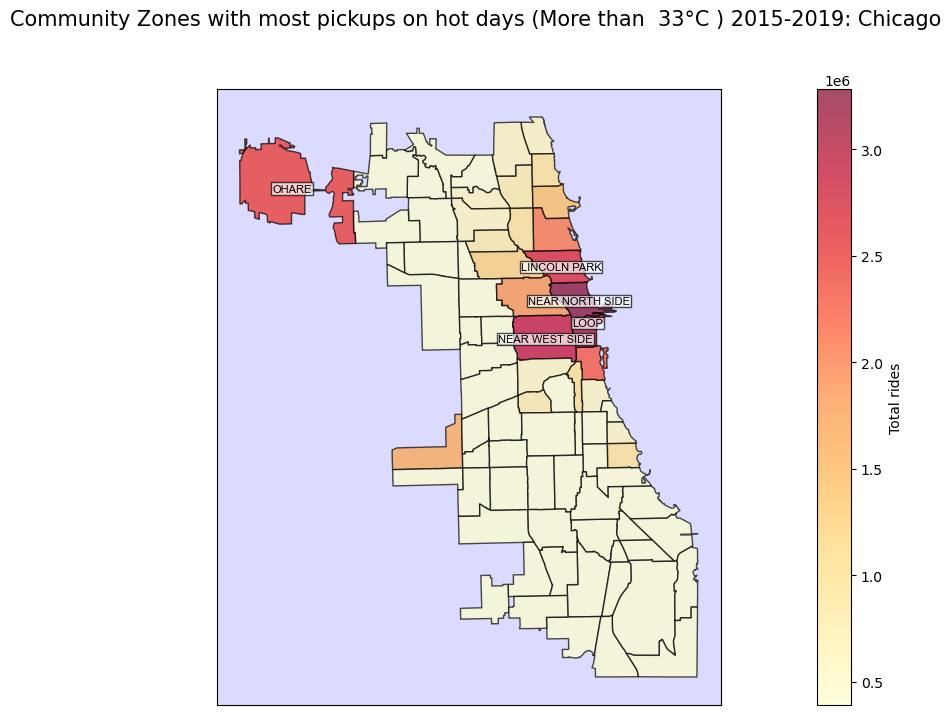

In [121]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Sort the DataFrame by 'trip_number' in descending order and get the top 5 zones
top_zones = dropoff_merge.sort_values('trip_number', ascending=False).head(5)

# Plot the data with more transparent facecolor
ax = dropoff_merge.plot(column='trip_number', scheme='fisher_jenks', k=15, cmap='YlOrRd', legend=False, edgecolor="black", alpha=0.7)
plt.suptitle('Community Zones with most pickups on hot days (More than  33°C ) 2015-2019: Chicago', size=15)
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

# Add colorbar with adjusted transparency
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=top_zones['trip_number'].min(), vmax=top_zones['trip_number'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, alpha=0.7)
cbar.set_label("Total rides")

# Manually adjust the positions of the text annotations
label_positions = [(x, y) for x, y in zip(top_zones.geometry.centroid.x, top_zones.geometry.centroid.y)]
label_offsets = [(0.001, -0.001), (0.001, 0.005), (0.001, -0.001), (0.001, -0.001), (0.001, -0.001)]

for i, label in enumerate(top_zones.community):
    ax.text(label_positions[i][0] + label_offsets[i][0], label_positions[i][1] + label_offsets[i][1], label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.1', alpha=0.7), fontname='Arial')

# Remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor((0.8, 0.8, 1, 0.7))  # Set facecolor with adjusted transparency

plt.show()

In [19]:
ca = gpd.read_file("Chigaco_data/boundaries_census_tracts_chicago_2010.geojson")
ca = ca.set_index('geoid10')
ca.reset_index(level=0, inplace=True)
ca.head()

,geoid10,statefp10,name10,commarea_n,namelsad10,commarea,notes,tractce10,countyfp10,geometry
0,17031842400,17,8424,44,Census Tract 8424,44,,842400,031,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ..."
1,17031840300,17,8403,59,Census Tract 8403,59,,840300,031,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ..."
2,17031841100,17,8411,34,Census Tract 8411,34,,841100,031,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ..."
3,17031841200,17,8412,31,Census Tract 8412,31,,841200,031,"MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ..."
4,17031839000,17,8390,32,Census Tract 8390,32,,839000,031,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ..."


In [24]:
pickup_aggregated = pd.read_csv("Chigaco_data/chicago_PU_regression_censustract.csv")

In [27]:
pickup = pickup_aggregated.groupby("PULocationID").agg({"trip_number" : "sum"}).reset_index()

pickup["PULocationID"] = pickup["PULocationID"].astype(str)

pickup_merge = ca.merge(pickup, left_on='geoid10', right_on = "PULocationID", how='left')
pickup_merge.fillna(value = 0, inplace=True)


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\geopandas\plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\geopandas\plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


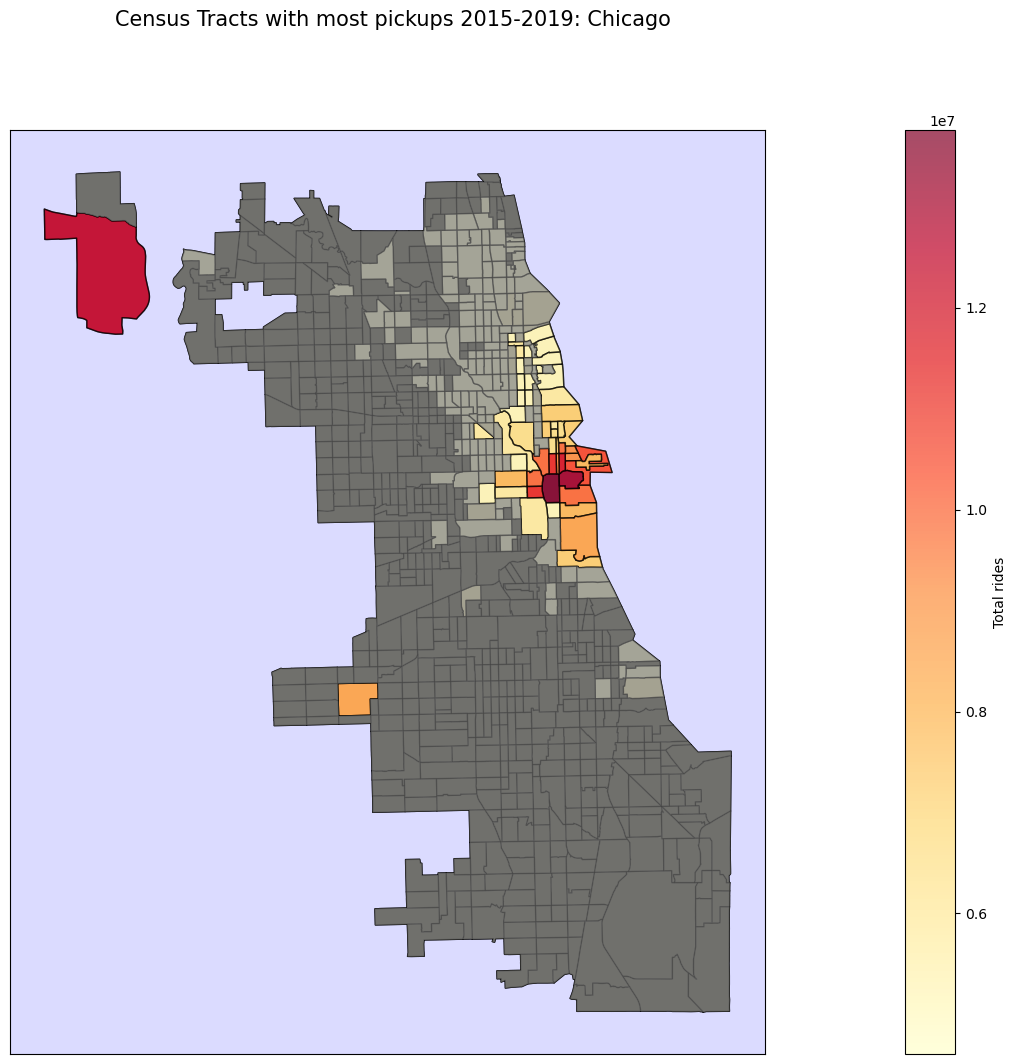

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Plot the data with more transparent facecolor
ax = pickup_merge.plot(column='trip_number', scheme='fisher_jenks', k=15, cmap='YlOrRd', legend=False, edgecolor="black", alpha=0.7)
plt.suptitle('Census Tracts with most pickups 2015-2019: Chicago', size=15)
mpl.rcParams['figure.figsize'] = (20.0, 12.0)

# Add colorbar with adjusted transparency
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=top_zones['trip_number'].min(), vmax=top_zones['trip_number'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, alpha=0.7)
cbar.set_label("Total rides")


# color all the areas with less than 1000 rides in black
pickup_merge.plot(column='trip_number', scheme='fisher_jenks', k=15, cmap='YlOrRd', legend=False, edgecolor="black", alpha=0.7, ax=ax)
pickup_merge[pickup_merge["trip_number"] < 1000].plot(color="black", ax=ax, alpha=0.7)
# color all areas with less than 100000 rides in grey
pickup_merge[pickup_merge["trip_number"] < 100000].plot(color="grey", ax=ax, alpha=0.7)

# Remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor((0.8, 0.8, 1, 0.7))  # Set facecolor with adjusted transparency

plt.show()


##### Temperature Plots

In [3]:
DC_PU = pickup_aggregated

Index(['(-14.0, -11.0]', '(-11.0, -8.0]', '(-8.0, -5.0]', '(-5.0, -2.0]',
       '(-2.0, 1.0]', '(1.0, 4.0]', '(4.0, 7.0]', '(7.0, 10.0]',
       '(10.0, 13.0]', '(13.0, 16.0]', '(16.0, 19.0]', '(19.0, 22.0]',
       '(22.0, 25.0]', '(25.0, 28.0]', '(28.0, 31.0]', '(31.0, 34.0]',
       '(34.0, 37.0]'],
      dtype='object')


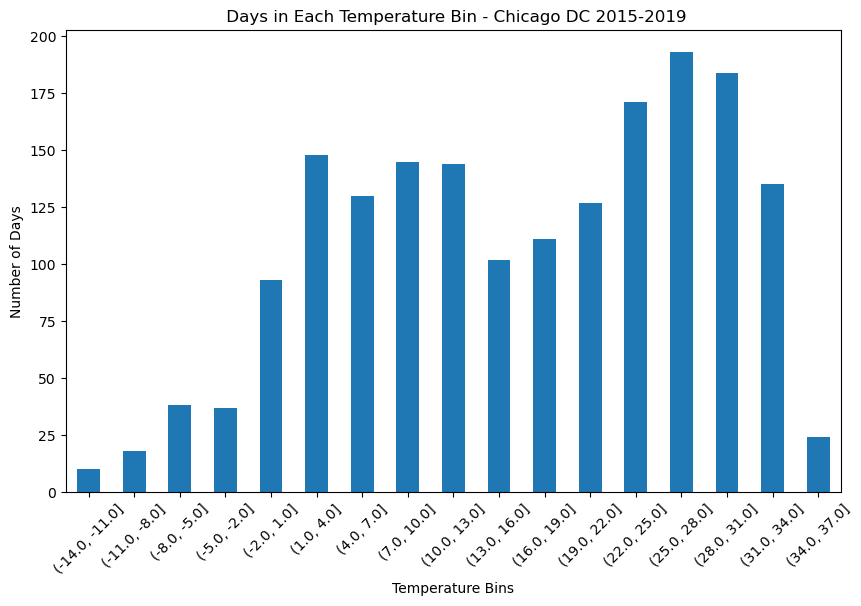

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'DC_PU' is your DataFrame

# Explicitly define the correct order of your temperature bins
ordered_temp_bins = [
    '(-14.0, -11.0]', '(-11.0, -8.0]', '(-8.0, -5.0]',
    '(-5.0, -2.0]', '(-2.0, 1.0]', '(1.0, 4.0]',
    '(4.0, 7.0]', '(7.0, 10.0]', '(10.0, 13.0]',
    '(13.0, 16.0]', '(16.0, 19.0]', '(19.0, 22.0]',
    '(22.0, 25.0]', '(25.0, 28.0]', '(28.0, 31.0]',
    '(31.0, 34.0]', '(34.0, 37.0]'
]


# Convert the 'temp_bins' column to a categorical type with the specified order
DC_PU['temp_bins'] = pd.Categorical(DC_PU['temp_bins'], categories=ordered_temp_bins, ordered=True)

# Verify the order of categories
print(DC_PU['temp_bins'].cat.categories)

# Create a new DataFrame with unique days
unique_days = DC_PU[['date_pickup', 'temp_bins']].drop_duplicates()

# Count the occurrences of each bin, respecting the categorical order
temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10,6))
# Ensure the plot respects the categorical order
temp_bin_counts.reindex(ordered_temp_bins).plot(kind='bar')
plt.title(' Days in Each Temperature Bin - Chicago DC 2015-2019')
plt.xlabel('Temperature Bins')
plt.ylabel('Number of Days')
plt.xticks(rotation=45)
plt.show()
